In [ ]:
# Set whether this notebook is run in colab or not
colab = True

# Prepare folder (to run just the first time)

In [ ]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Initialization

In [ ]:
from tensorflow.python.client import device_lib

import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Settings for reproducibility
random_seed = 44
tf.random.set_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
#os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.keras.utils.set_random_seed(random_seed)


def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]


print('Available devices:', get_available_devices())

#tf.debugging.set_log_device_placement(True)

Available devices: ['/device:CPU:0', '/device:GPU:0']


In [ ]:
# Set mixed precision
# https://www.tensorflow.org/guide/mixed_precision
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float16
Variable dtype: float32


In [ ]:
# Path to the working directory
if colab:
    #%cd -0
    #%cd "/content/drive/MyDrive/green_areas_detection"
    #%cp -R "/content/drive/MyDrive/green_areas_detection/dataset" "./"
    base_dir = '/content/drive/MyDrive/green_areas_detection'
    %cp -R "/content/drive/MyDrive/green_areas_detection/green_areas_detection/models" "./"
    %cp -R "/content/drive/MyDrive/green_areas_detection/green_areas_detection/utils" "./"
    %cp -R "/content/drive/MyDrive/green_areas_detection/green_areas_detection/weights" "./"
else:
    base_dir = ''

In [ ]:
# TRANSFORMING SHP FILES INTO BINARY IMAGES (i.e. masks)

from utils.PyMask import shpToMask
import os 

dataset_folder = 'dataset_2011'
samples_names = os.listdir(dataset_folder)

valid_samples_names = ['19K59', '19K35', '19K38', '18K11', '19K53']

for sample_name in samples_names:
    if sample_name in valid_samples_names:
        sample_folder_path = os.path.join(dataset_folder, sample_name) 
        #print(sample_folder_path)
        img_path = os.path.join(sample_folder_path, f'{sample_name}.tif')
        #print(img_path)
        shp_path = os.path.join(sample_folder_path, 'green_areas_shp', f'{sample_name}_greenareas.shp')
        #print(shp_path)
        shpToMask(img_path, shp_path)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (98211778 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


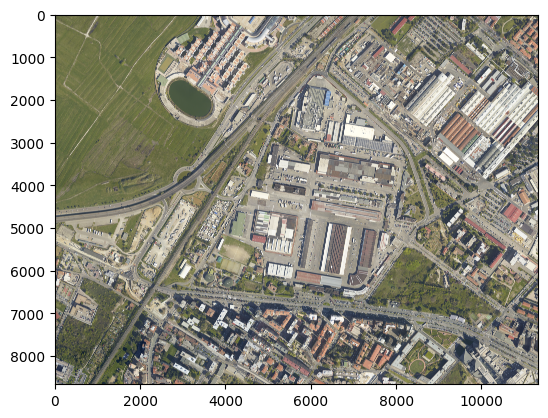

In [ ]:
# Visualize one image
img = Image.open(os.path.join(base_dir, 'dataset', '19K35', '19K35.tif'))
img = np.array(img)[:, :, :3]
plt.imshow(img)

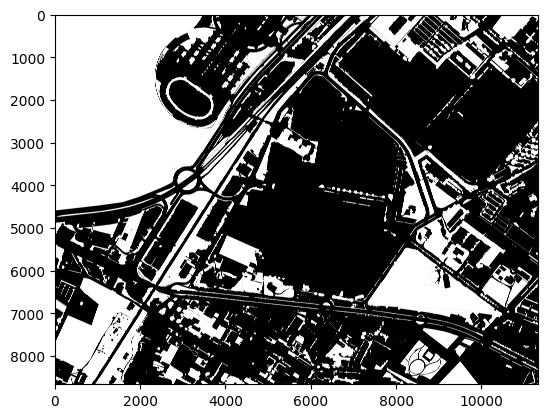

In [ ]:

# Visualize one mask
mask = Image.open(os.path.join(base_dir, 'dataset', '19K35', '19K35_mask.png'))
mask = np.array(mask)
plt.imshow(mask)

# Prepare dataset

### Load dataset

We use $4$ images for the training : `19K35`, `19K38`, `19K53`, `18K11`.

We use $1$ image for the validation : `19K59`.  

We use only the RGB channels.

In [ ]:
from utils.dataset_handler import load_images_masks

dataset_folder = os.path.join(base_dir, 'dataset_2011')
#samples_names = os.listdir(dataset_folder)

#valid_samples_names = ['19K35', '19K38']
train_samples_names = ['19K35', '19K38', '19K53', '18K11']
val_samples_names = ['19K59']
test_samples_names = []

train_images, train_masks = load_images_masks(dataset_folder, train_samples_names, infrared=False)
print('Train shapes:', train_images.shape, train_masks.shape)

val_images, val_masks = load_images_masks(dataset_folder, val_samples_names, infrared=False)
print('Val shapes:', val_images.shape, val_masks.shape)

test_images, test_masks = load_images_masks(dataset_folder, test_samples_names, infrared=False)
print('Test shapes:', test_images.shape, test_masks.shape)

Train shapes: (4, 6200, 8200, 3) (4, 6200, 8200, 1)
Val shapes: (1, 6200, 8200, 3) (1, 6200, 8200, 1)
Test shapes: (0,) (0,)


### Crop dataset

In [ ]:
from utils.dataset_handler import crop_images_masks

crop_size = 1024
step = 512

train_cropped_images, train_cropped_masks = crop_images_masks(train_images, train_masks, crop_size, step)
print('Train shapes:', train_cropped_images.shape, train_cropped_masks.shape)

val_cropped_images, val_cropped_masks = crop_images_masks(val_images, val_masks, crop_size, step)
print('Val shapes:', val_cropped_images.shape, val_cropped_masks.shape)

#test_cropped_images, test_cropped_masks = crop(test_images, test_masks, crop_size, step)
#print('Test shapes:', test_cropped_images.shape, test_cropped_masks.shape)

Train shapes: (768, 1024, 1024, 3) (768, 1024, 1024, 1)
Val shapes: (192, 1024, 1024, 3) (192, 1024, 1024, 1)


<Figure size 640x480 with 0 Axes>

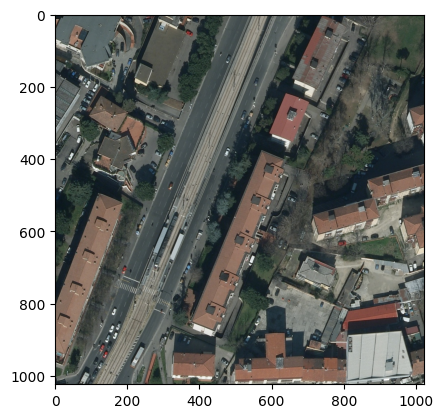

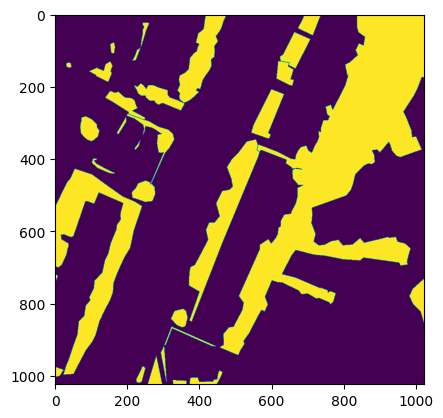

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize one crop image and mask
index = 36
plt.imshow(val_cropped_images[index, :, :])
plt.figure()
#plt.imshow(infrared[index, :, :])
#plt.figure()
plt.imshow(val_cropped_masks[index, :, :])
plt.figure()

### Normalizing the input: NO

In [ ]:
# Normalizing input images
# NO: much more RAM memory recquired. Over 60GB RAM.
# We keep integer values: no worse results

#images_dataset = images_dataset.astype(np.float16)/255
#images_dataset.min(), images_dataset.max()

# Unet

In [ ]:
from models.green_areas_detection_models import build_unet
unet = build_unet(input_shape=(crop_size,crop_size,3))

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 32)         0         ['batch_normalization[0][0

### Train

In [ ]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from models.callbacks import DisplayCallback

reduce_lr_callback = ReduceLROnPlateau(monitor='loss', patience=3, min_delta=0.01)

callback_checkpoint = ModelCheckpoint('UNET.{epoch:02d}-{val_binary_accuracy:.4f}.hdf5', save_weights_only=True,
                                      save_best_only=True, monitor='val_binary_accuracy')

"""earlystopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)"""

# Visualize evolution of the predictions on the 37th validation crop during training
index = 36
display_callback = DisplayCallback(val_cropped_images[index, :, :], val_cropped_masks[index, :, :], 5)

callbacks = [reduce_lr_callback, callback_checkpoint, display_callback] #, earlystopping_callback]

Epoch 1/30
1/1 [==============================] - 1s 1s/step


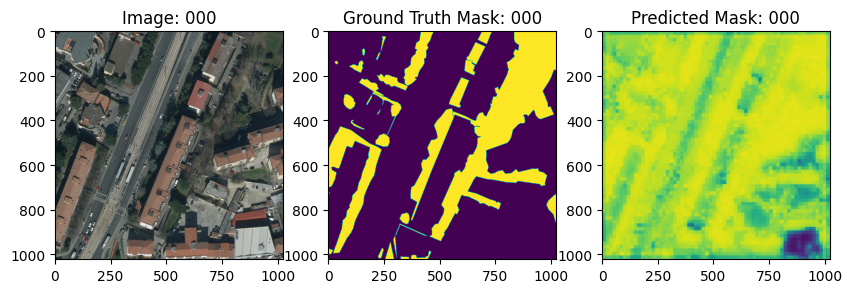

192/192 [==============================] - 111s 374ms/step - loss: 0.4650 - binary_accuracy: 0.8559 - val_loss: 1.2417 - val_binary_accuracy: 0.4063 - lr: 0.0010
Epoch 2/30
192/192 [==============================] - 68s 354ms/step - loss: 0.2466 - binary_accuracy: 0.9076 - val_loss: 1.1794 - val_binary_accuracy: 0.4635 - lr: 0.0010
Epoch 3/30
192/192 [==============================] - 68s 355ms/step - loss: 0.1758 - binary_accuracy: 0.9333 - val_loss: 0.2261 - val_binary_accuracy: 0.9134 - lr: 0.0010
Epoch 4/30
192/192 [==============================] - 68s 354ms/step - loss: 0.1595 - binary_accuracy: 0.9381 - val_loss: 0.1793 - val_binary_accuracy: 0.9271 - lr: 0.0010
Epoch 5/30
192/192 [==============================] - 68s 353ms/step - loss: 0.1396 - binary_accuracy: 0.9458 - val_loss: 0.1921 - val_binary_accuracy: 0.9215 - lr: 0.0010
Epoch 6/30
1/1 [==============================] - 0s 22ms/step


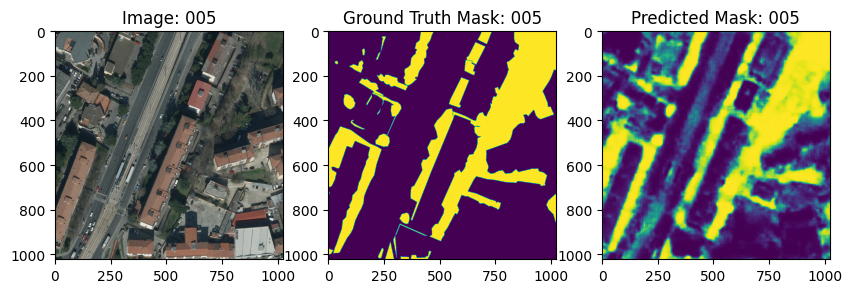

192/192 [==============================] - 69s 358ms/step - loss: 0.1381 - binary_accuracy: 0.9465 - val_loss: 0.2197 - val_binary_accuracy: 0.9101 - lr: 0.0010
Epoch 7/30
192/192 [==============================] - 68s 354ms/step - loss: 0.1278 - binary_accuracy: 0.9496 - val_loss: 0.3792 - val_binary_accuracy: 0.8753 - lr: 0.0010
Epoch 8/30
192/192 [==============================] - 68s 353ms/step - loss: 0.1174 - binary_accuracy: 0.9538 - val_loss: 0.2472 - val_binary_accuracy: 0.9033 - lr: 0.0010
Epoch 9/30
192/192 [==============================] - 68s 354ms/step - loss: 0.1056 - binary_accuracy: 0.9580 - val_loss: 0.1760 - val_binary_accuracy: 0.9305 - lr: 0.0010
Epoch 10/30
192/192 [==============================] - 68s 354ms/step - loss: 0.1002 - binary_accuracy: 0.9601 - val_loss: 0.1980 - val_binary_accuracy: 0.9250 - lr: 0.0010
Epoch 11/30
1/1 [==============================] - 0s 21ms/step


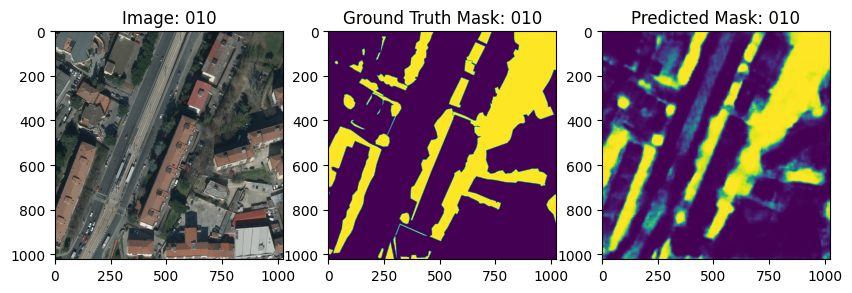

192/192 [==============================] - 69s 357ms/step - loss: 0.1025 - binary_accuracy: 0.9595 - val_loss: 0.1785 - val_binary_accuracy: 0.9284 - lr: 0.0010
Epoch 12/30
192/192 [==============================] - 68s 354ms/step - loss: 0.0960 - binary_accuracy: 0.9623 - val_loss: 0.1713 - val_binary_accuracy: 0.9307 - lr: 0.0010
Epoch 13/30
192/192 [==============================] - 68s 354ms/step - loss: 0.0762 - binary_accuracy: 0.9696 - val_loss: 0.1574 - val_binary_accuracy: 0.9382 - lr: 1.0000e-04
Epoch 14/30
192/192 [==============================] - 68s 353ms/step - loss: 0.0725 - binary_accuracy: 0.9711 - val_loss: 0.1610 - val_binary_accuracy: 0.9375 - lr: 1.0000e-04
Epoch 15/30
192/192 [==============================] - 68s 354ms/step - loss: 0.0707 - binary_accuracy: 0.9717 - val_loss: 0.1626 - val_binary_accuracy: 0.9382 - lr: 1.0000e-04
Epoch 16/30
1/1 [==============================] - 0s 21ms/step


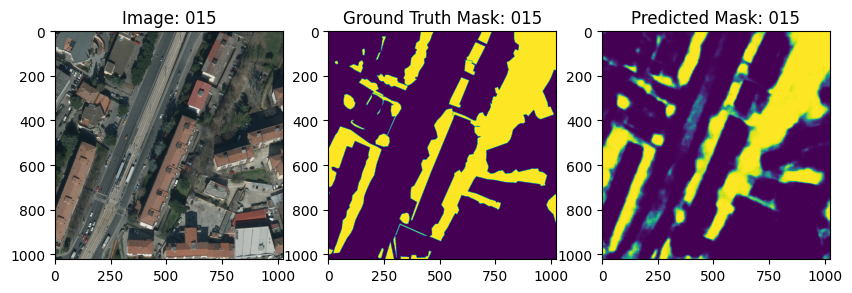

192/192 [==============================] - 69s 358ms/step - loss: 0.0683 - binary_accuracy: 0.9728 - val_loss: 0.1658 - val_binary_accuracy: 0.9373 - lr: 1.0000e-04
Epoch 17/30
192/192 [==============================] - 68s 354ms/step - loss: 0.0661 - binary_accuracy: 0.9736 - val_loss: 0.1646 - val_binary_accuracy: 0.9370 - lr: 1.0000e-05
Epoch 18/30
192/192 [==============================] - 68s 355ms/step - loss: 0.0663 - binary_accuracy: 0.9736 - val_loss: 0.1643 - val_binary_accuracy: 0.9369 - lr: 1.0000e-05
Epoch 19/30
192/192 [==============================] - 68s 356ms/step - loss: 0.0660 - binary_accuracy: 0.9737 - val_loss: 0.1651 - val_binary_accuracy: 0.9367 - lr: 1.0000e-05
Epoch 20/30
192/192 [==============================] - 68s 355ms/step - loss: 0.0657 - binary_accuracy: 0.9738 - val_loss: 0.1643 - val_binary_accuracy: 0.9371 - lr: 1.0000e-05
Epoch 21/30
1/1 [==============================] - 0s 23ms/step


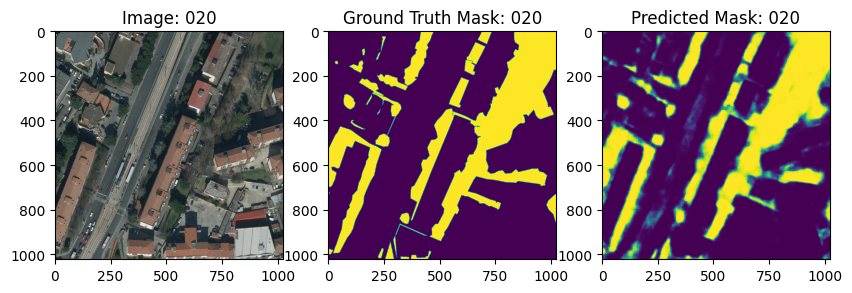

192/192 [==============================] - 69s 359ms/step - loss: 0.0655 - binary_accuracy: 0.9739 - val_loss: 0.1643 - val_binary_accuracy: 0.9370 - lr: 1.0000e-06
Epoch 22/30
192/192 [==============================] - 68s 354ms/step - loss: 0.0659 - binary_accuracy: 0.9738 - val_loss: 0.1643 - val_binary_accuracy: 0.9369 - lr: 1.0000e-06
Epoch 23/30
192/192 [==============================] - 68s 354ms/step - loss: 0.0649 - binary_accuracy: 0.9741 - val_loss: 0.1651 - val_binary_accuracy: 0.9370 - lr: 1.0000e-06
Epoch 24/30
192/192 [==============================] - 68s 354ms/step - loss: 0.0650 - binary_accuracy: 0.9741 - val_loss: 0.1651 - val_binary_accuracy: 0.9369 - lr: 1.0000e-07
Epoch 25/30
192/192 [==============================] - 68s 354ms/step - loss: 0.0655 - binary_accuracy: 0.9739 - val_loss: 0.1645 - val_binary_accuracy: 0.9369 - lr: 1.0000e-07
Epoch 26/30
1/1 [==============================] - 0s 21ms/step


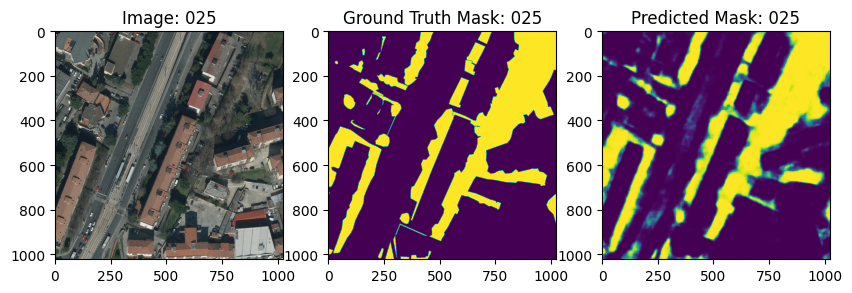

192/192 [==============================] - 69s 358ms/step - loss: 0.0648 - binary_accuracy: 0.9742 - val_loss: 0.1650 - val_binary_accuracy: 0.9370 - lr: 1.0000e-07
Epoch 27/30
192/192 [==============================] - 68s 354ms/step - loss: 0.0654 - binary_accuracy: 0.9739 - val_loss: 0.1643 - val_binary_accuracy: 0.9370 - lr: 1.0000e-08
Epoch 28/30
192/192 [==============================] - 68s 354ms/step - loss: 0.0655 - binary_accuracy: 0.9739 - val_loss: 0.1644 - val_binary_accuracy: 0.9371 - lr: 1.0000e-08
Epoch 29/30
192/192 [==============================] - 68s 354ms/step - loss: 0.0649 - binary_accuracy: 0.9741 - val_loss: 0.1646 - val_binary_accuracy: 0.9370 - lr: 1.0000e-08
Epoch 30/30
192/192 [==============================] - 68s 354ms/step - loss: 0.0651 - binary_accuracy: 0.9741 - val_loss: 0.1650 - val_binary_accuracy: 0.9370 - lr: 1.0000e-09


In [ ]:
#2011
hist = unet.fit(train_cropped_images, train_cropped_masks, batch_size=4,
                epochs=30, callbacks=callbacks,
                validation_data=(val_cropped_images,val_cropped_masks))

Best validation score: $0.9382$, epoch $15$.
Associated training score: $0.9717$.

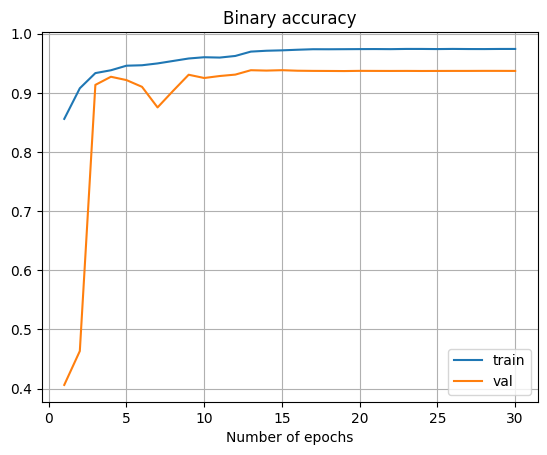

In [ ]:
from utils.evaluation import plot_history
plot_history(hist)

### Load best model

In [ ]:
#unet.load_weights(os.path.join('weights', 'UNET.15-0.9484.hdf5'))
unet.load_weights('UNET.15-0.9382.hdf5')

### Visualize the predictions on a validation crop

(1024, 1024, 3)
1/1 [==============================] - 0s 26ms/step


<Figure size 640x480 with 0 Axes>

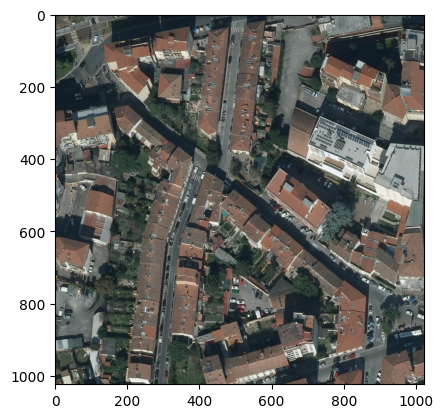

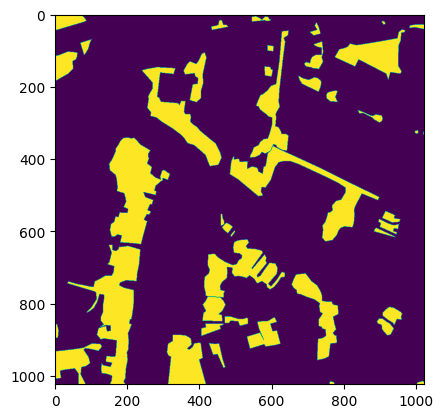

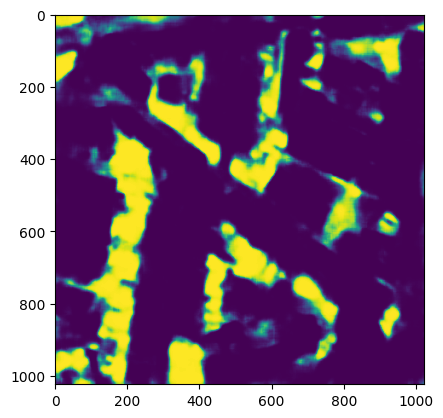

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize the predicted scores on a validation crop

index = 12
img = val_cropped_images[index, :, :, :]
mask = val_cropped_masks[index, :, :, 0]

plt.imshow(img)
plt.figure()

plt.imshow(mask, vmin=0, vmax=1)
plt.figure()

print(img.shape)
img = np.expand_dims(img, axis=0)
pred = unet.predict(img)
binary_preds = np.argmax(pred, axis=-1).astype('uint8')
binary_preds = binary_preds[0, :]
#binary_mask = Image.fromarray(binary_preds)
#plt.imshow(binary_preds[..., 0])#cmap='gray', vmin=0, vmax=1)
plt.imshow(pred[0, :, :, 0], vmin=0, vmax=1)
plt.figure()

### Validation crops evaluation
Evaluation on the validation crops.

In [ ]:
from utils.evaluation import compute_pixelwise_retrieval_metrics

val_cropped_preds = unet.predict(val_cropped_images, batch_size=4)
compute_pixelwise_retrieval_metrics(val_cropped_preds[..., 0], val_cropped_masks[..., 0])

48/48 [==============================] - 5s 102ms/step


{'auroc': 0.9850935294414818,
 'fpr': array([0.00000000e+00, 1.62997380e-07, 7.49787947e-07, ...,
        9.99999870e-01, 9.99999935e-01, 1.00000000e+00]),
 'tpr': array([0.00000000e+00, 1.95051886e-04, 8.45491930e-04, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'optimal_threshold': 0.5056379,
 'optimal_fpr': 0.030788501103719074,
 'optimal_fnr': 0.030944029490152996}

Auroc: $0.9851$. Optimal threshold: $0.5056$.

### Validation full image evaluation
Evaluation on the full validation image. First on the binary predictions, and then on the polylines mask.


**1) Binary predictions**

In [ ]:
from utils.utils import predict_on_img

val_img = val_images[0]
val_mask = val_masks[0]

# Predictions on the full validation image.
# (Basically, aggregation of the predictions on the crops).
val_preds = predict_on_img(unet, val_img, step=step, batch_size=4,
                           crop_size=crop_size, use_gaussian=False);

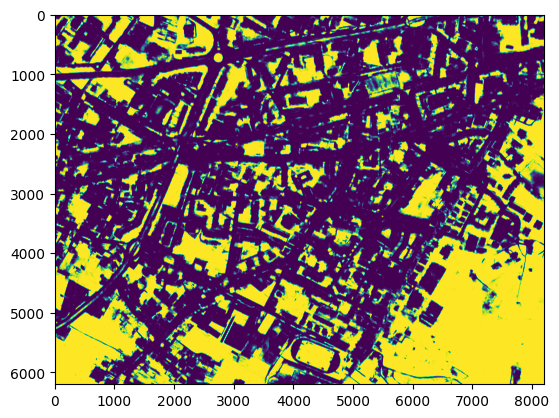

In [ ]:
plt.imshow(val_preds)

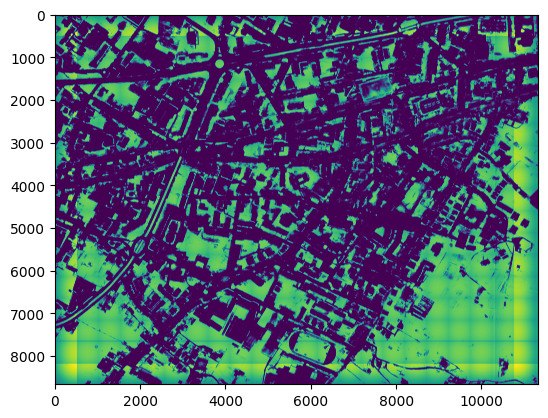

In [ ]:
# TO DELETE
# With gaussian smoothing
plt.imshow(val_preds)

In [ ]:
# NEW
# Compute the binary accuracy
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(val_mask, val_preds)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.93753237>

Binary accuracy: $0.9375$.

In [ ]:
# With best threshold
threshold = 0.5056
acc = tf.keras.metrics.BinaryAccuracy(threshold=threshold)
acc.update_state(val_mask, val_preds)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.93759376>

In [ ]:
compute_pixelwise_retrieval_metrics(val_preds[..., 0], val_mask[..., 0])

{'auroc': 0.9845585506369933,
 'fpr': array([0.00000000e+00, 1.42478420e-04, 3.25993396e-04, ...,
        9.89433417e-01, 9.94719827e-01, 1.00000000e+00]),
 'tpr': array([0.        , 0.27786338, 0.42935771, ..., 1.        , 1.        ,
        1.        ]),
 'optimal_threshold': 0.506,
 'optimal_fpr': 0.03147619984264359,
 'optimal_fnr': 0.030930055074744296}


Auroc: $0.9375$. Best threshold: $0.506$.

**2) Polylines mask**

In [ ]:
from PIL import ImageDraw
from utils.utils import get_polylines

# Thresholded binary predictions: either 0 or 1
binary_preds = (val_preds>threshold).astype('uint8')

# Compute the poly-lines
tolerance = 1.
min_area = 10
poly_lines = get_polylines(binary_preds, tolerance=tolerance, min_area=min_area)

# Compute the polylines mask
polyline_mask = np.zeros(shape=binary_preds.shape[:2], dtype=np.uint8)
polyline_mask = Image.fromarray(polyline_mask)
draw_polyline = ImageDraw.Draw(polyline_mask)
for p in poly_lines:
    draw_polyline.polygon(p, fill=1)
#polyline_mask.putpalette(get_palette())
#polyline_mask.save(join(out_folder, f"{img_basename}_polylines.png"))
polyline_mask = np.array(polyline_mask)

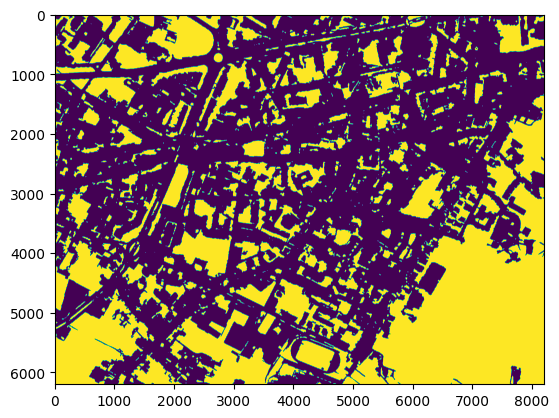

In [ ]:
plt.imshow(polyline_mask)

In [ ]:
# Compute the binary accuracy
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(val_mask, polyline_mask)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9283601>

Binary accuracy: $0.9284$. Slightly worse than before ...

*The vectorization process makes the mask better looking and more regular. The price to pay is some points of the accuracy...*

In [ ]:
compute_pixelwise_retrieval_metrics(polyline_mask, val_mask[..., 0])

{'auroc': 0.9274545979040095,
 'fpr': array([0.        , 0.06891046, 1.        ]),
 'tpr': array([0.        , 0.92381965, 1.        ]),
 'optimal_threshold': 1,
 'optimal_fpr': 0.04303809992132179,
 'optimal_fnr': 0.028601829268292682}

### Save the polylines mask

In [ ]:
# Save polylines mask
from utils.utils import get_palette
m = Image.fromarray(polyline_mask)
m.putpalette(get_palette())
m.save("polylines.png")

# Attention Unet

In [ ]:
from models.green_areas_detection_models import build_attunet
att_unet = build_attunet(input_shape=(crop_size,crop_size,3), n_ch=32, L=3)

In [ ]:
att_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 1024, 32)       896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 1024, 32)       128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 1024, 1024, 32)       0         ['batch_normalization[0][0

In [ ]:
"""from sklearn.model_selection import train_test_split
(images_dataset_train, images_dataset_val,
 masks_dataset_train, masks_dataset_val) =  train_test_split(images_dataset,
                                                             masks_dataset,
                                                             test_size=0.2,
                                                             random_state=random_seed)"""

'from sklearn.model_selection import train_test_split\n(images_dataset_train, images_dataset_val,\n masks_dataset_train, masks_dataset_val) =  train_test_split(images_dataset,\n                                                             masks_dataset,\n                                                             test_size=0.2,\n                                                             random_state=random_seed)'

### Train

In [ ]:
att_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from models.callbacks import DisplayCallback

reduce_lr_callback = ReduceLROnPlateau(monitor='loss', patience=3, min_delta=0.01)

callback_checkpoint = ModelCheckpoint('ATT_UNET.{epoch:02d}-{val_binary_accuracy:.4f}.hdf5', save_weights_only=True,
                                      save_best_only=True, monitor='val_binary_accuracy')

"""earlystopping_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)"""

# Visualize evolution of the predictions on the 37th validation crop during training
index = 36
display_callback = DisplayCallback(val_cropped_images[index, :, :], val_cropped_masks[index, :, :], 5)

callbacks = [reduce_lr_callback, callback_checkpoint, display_callback] #, earlystopping_callback]

Epoch 1/30
1/1 [==============================] - 4s 4s/step


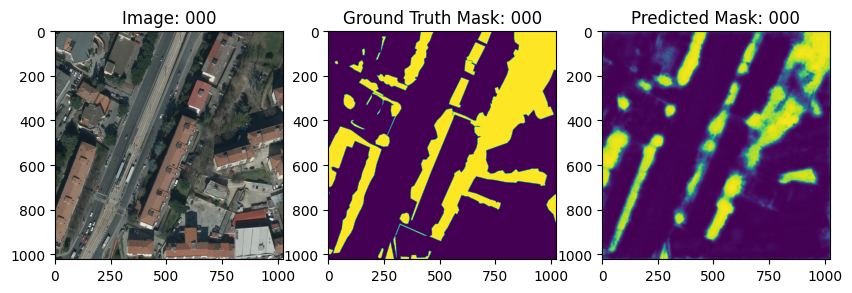

192/192 [==============================] - 534s 1s/step - loss: 0.4234 - binary_accuracy: 0.8651 - val_loss: 0.3790 - val_binary_accuracy: 0.8657 - lr: 0.0010
Epoch 2/30
192/192 [==============================] - 262s 1s/step - loss: 0.3661 - binary_accuracy: 0.9025 - val_loss: 0.2734 - val_binary_accuracy: 0.9026 - lr: 0.0010
Epoch 3/30
192/192 [==============================] - 262s 1s/step - loss: 0.3268 - binary_accuracy: 0.9287 - val_loss: 0.3683 - val_binary_accuracy: 0.8793 - lr: 0.0010
Epoch 4/30
192/192 [==============================] - 262s 1s/step - loss: 0.2955 - binary_accuracy: 0.9384 - val_loss: 0.2846 - val_binary_accuracy: 0.8945 - lr: 0.0010
Epoch 5/30
192/192 [==============================] - 261s 1s/step - loss: 0.2900 - binary_accuracy: 0.9331 - val_loss: 0.3508 - val_binary_accuracy: 0.8837 - lr: 0.0010
Epoch 6/30
1/1 [==============================] - 0s 25ms/step


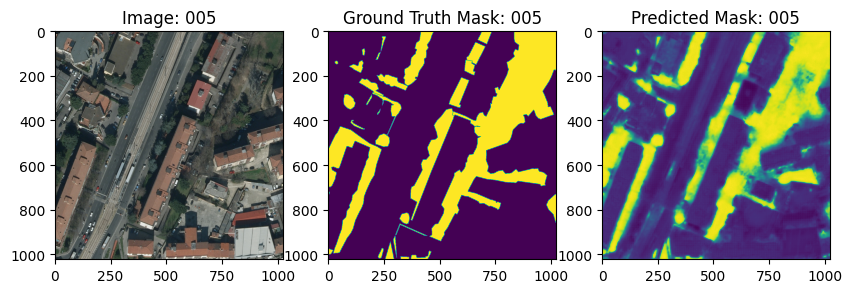

192/192 [==============================] - 262s 1s/step - loss: 0.2638 - binary_accuracy: 0.9464 - val_loss: 0.2426 - val_binary_accuracy: 0.9372 - lr: 0.0010
Epoch 7/30
192/192 [==============================] - 262s 1s/step - loss: 0.2448 - binary_accuracy: 0.9493 - val_loss: 0.2677 - val_binary_accuracy: 0.8965 - lr: 0.0010
Epoch 8/30
192/192 [==============================] - 261s 1s/step - loss: 0.2255 - binary_accuracy: 0.9514 - val_loss: 0.3073 - val_binary_accuracy: 0.9015 - lr: 0.0010
Epoch 9/30
192/192 [==============================] - 262s 1s/step - loss: 0.2100 - binary_accuracy: 0.9551 - val_loss: 0.2329 - val_binary_accuracy: 0.9242 - lr: 0.0010
Epoch 10/30
192/192 [==============================] - 261s 1s/step - loss: 0.2000 - binary_accuracy: 0.9564 - val_loss: 0.2015 - val_binary_accuracy: 0.9352 - lr: 0.0010
Epoch 11/30
1/1 [==============================] - 0s 27ms/step


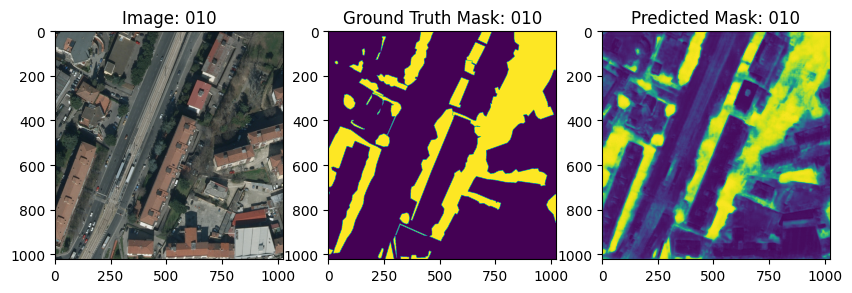

192/192 [==============================] - 263s 1s/step - loss: 0.1973 - binary_accuracy: 0.9550 - val_loss: 0.2419 - val_binary_accuracy: 0.9250 - lr: 0.0010
Epoch 12/30
192/192 [==============================] - 262s 1s/step - loss: 0.1901 - binary_accuracy: 0.9581 - val_loss: 0.2443 - val_binary_accuracy: 0.9088 - lr: 0.0010
Epoch 13/30
192/192 [==============================] - 262s 1s/step - loss: 0.1774 - binary_accuracy: 0.9603 - val_loss: 0.1899 - val_binary_accuracy: 0.9421 - lr: 0.0010
Epoch 14/30
192/192 [==============================] - 262s 1s/step - loss: 0.1740 - binary_accuracy: 0.9613 - val_loss: 0.1841 - val_binary_accuracy: 0.9344 - lr: 0.0010
Epoch 15/30
192/192 [==============================] - 262s 1s/step - loss: 0.1662 - binary_accuracy: 0.9609 - val_loss: 0.1858 - val_binary_accuracy: 0.9350 - lr: 0.0010
Epoch 16/30
1/1 [==============================] - 0s 24ms/step


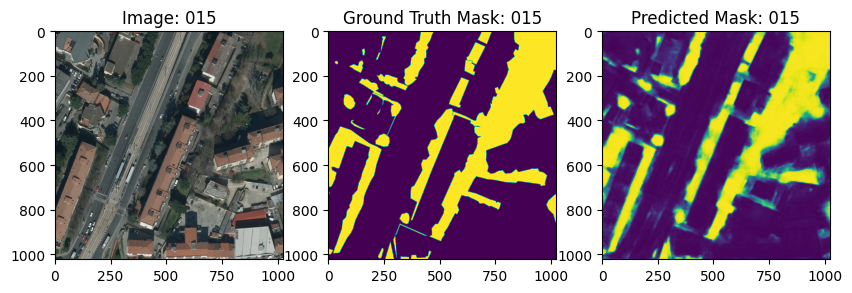

192/192 [==============================] - 262s 1s/step - loss: 0.1580 - binary_accuracy: 0.9618 - val_loss: 0.1713 - val_binary_accuracy: 0.9379 - lr: 0.0010
Epoch 17/30
192/192 [==============================] - 261s 1s/step - loss: 0.1445 - binary_accuracy: 0.9643 - val_loss: 0.1802 - val_binary_accuracy: 0.9333 - lr: 0.0010
Epoch 18/30
192/192 [==============================] - 261s 1s/step - loss: 0.1563 - binary_accuracy: 0.9611 - val_loss: 0.1953 - val_binary_accuracy: 0.9235 - lr: 0.0010
Epoch 19/30
192/192 [==============================] - 261s 1s/step - loss: 0.1463 - binary_accuracy: 0.9615 - val_loss: 0.1731 - val_binary_accuracy: 0.9382 - lr: 0.0010
Epoch 20/30
192/192 [==============================] - 261s 1s/step - loss: 0.1342 - binary_accuracy: 0.9669 - val_loss: 0.1756 - val_binary_accuracy: 0.9363 - lr: 0.0010
Epoch 21/30
1/1 [==============================] - 0s 22ms/step


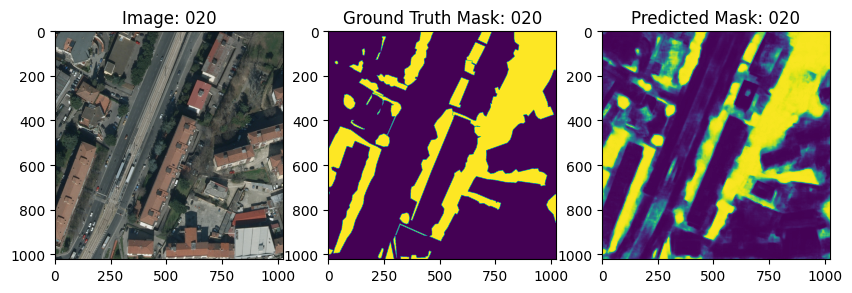

192/192 [==============================] - 262s 1s/step - loss: 0.1440 - binary_accuracy: 0.9659 - val_loss: 0.1806 - val_binary_accuracy: 0.9310 - lr: 0.0010
Epoch 22/30
192/192 [==============================] - 261s 1s/step - loss: 0.1381 - binary_accuracy: 0.9655 - val_loss: 0.1637 - val_binary_accuracy: 0.9391 - lr: 0.0010
Epoch 23/30
192/192 [==============================] - 261s 1s/step - loss: 0.1132 - binary_accuracy: 0.9698 - val_loss: 0.1728 - val_binary_accuracy: 0.9354 - lr: 0.0010
Epoch 24/30
192/192 [==============================] - 261s 1s/step - loss: 0.1219 - binary_accuracy: 0.9666 - val_loss: 0.1514 - val_binary_accuracy: 0.9425 - lr: 0.0010
Epoch 25/30
192/192 [==============================] - 261s 1s/step - loss: 0.1130 - binary_accuracy: 0.9707 - val_loss: 0.1665 - val_binary_accuracy: 0.9376 - lr: 0.0010
Epoch 26/30
1/1 [==============================] - 0s 22ms/step


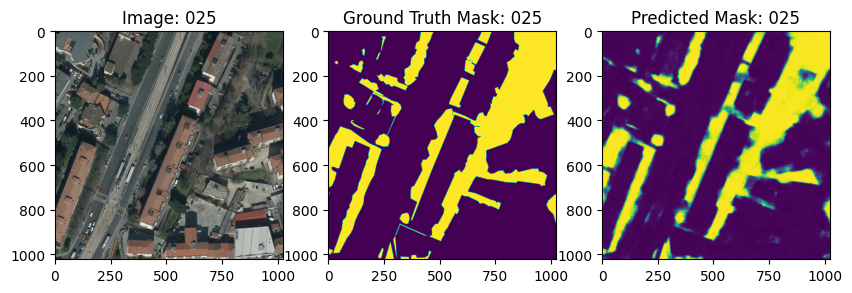

192/192 [==============================] - 262s 1s/step - loss: 0.0976 - binary_accuracy: 0.9729 - val_loss: 0.1600 - val_binary_accuracy: 0.9403 - lr: 0.0010
Epoch 27/30
192/192 [==============================] - 262s 1s/step - loss: 0.1235 - binary_accuracy: 0.9658 - val_loss: 0.1714 - val_binary_accuracy: 0.9335 - lr: 0.0010
Epoch 28/30
192/192 [==============================] - 261s 1s/step - loss: 0.1062 - binary_accuracy: 0.9714 - val_loss: 0.1639 - val_binary_accuracy: 0.9362 - lr: 0.0010
Epoch 29/30
192/192 [==============================] - 261s 1s/step - loss: 0.0940 - binary_accuracy: 0.9744 - val_loss: 0.2401 - val_binary_accuracy: 0.9077 - lr: 0.0010
Epoch 30/30
192/192 [==============================] - 261s 1s/step - loss: 0.0857 - binary_accuracy: 0.9766 - val_loss: 0.1573 - val_binary_accuracy: 0.9393 - lr: 1.0000e-04


In [16]:
#2011
# System RAM : ~25GB
# GPU RAM : ~15GB

hist = att_unet.fit(train_cropped_images, train_cropped_masks, batch_size=4,
                epochs=30, callbacks=callbacks,
                validation_data=(val_cropped_images,val_cropped_masks))

Best validation score: $0.9425$, epoch $24$.
Associated training score: $0.9667$.

Better than UNET!

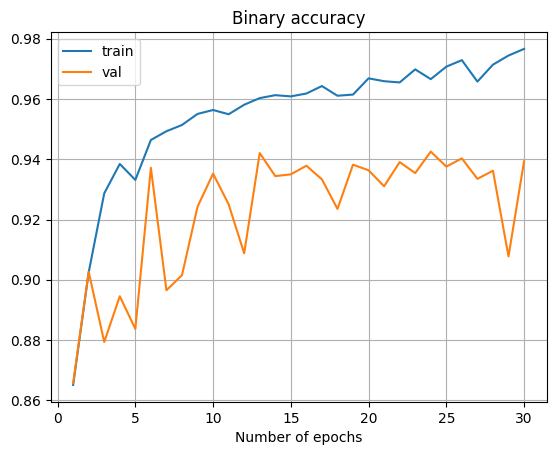

In [18]:
from utils.evaluation import plot_history
plot_history(hist)

### Load best model

In [19]:
#att_unet.load_weights(os.path.join('weights', 'ATT_UNET.25-0.9492.hdf5'))
att_unet.load_weights('/content/ATT_UNET.24-0.9425.hdf5')

### Visualize the predictions on a validation crop

(1024, 1024, 3)
1/1 [==============================] - 0s 25ms/step


<Figure size 640x480 with 0 Axes>

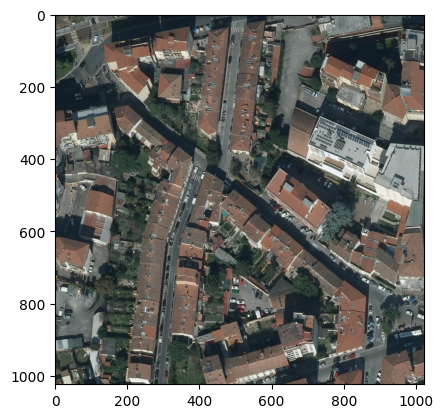

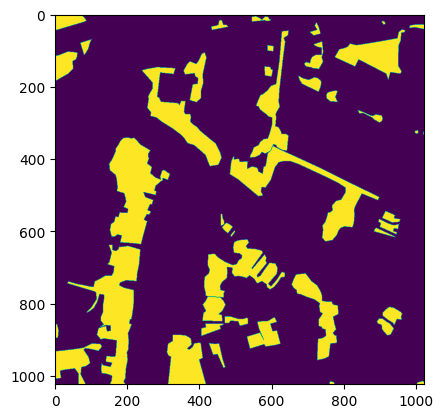

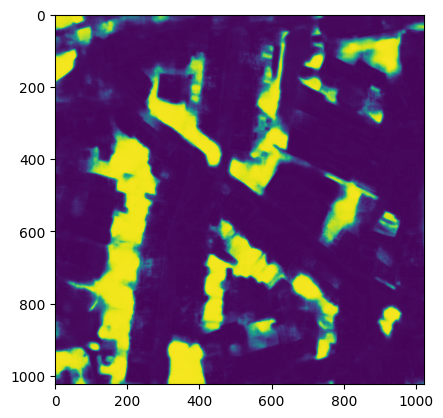

<Figure size 640x480 with 0 Axes>

In [20]:
# Visualize the predicted scores on a validation crop

index = 12
img = val_cropped_images[index, :, :, :]
mask = val_cropped_masks[index, :, :, 0]

plt.imshow(img)
plt.figure()

plt.imshow(mask, vmin=0, vmax=1)
plt.figure()

print(img.shape)
img = np.expand_dims(img, axis=0)
pred = att_unet.predict(img)
binary_preds = np.argmax(pred, axis=-1).astype('uint8')
binary_preds = binary_preds[0, :]
#binary_mask = Image.fromarray(binary_preds)
#plt.imshow(binary_preds[..., 0])#cmap='gray', vmin=0, vmax=1)
plt.imshow(pred[0, :, :, 0], vmin=0, vmax=1)
plt.figure()

### Validation crops evaluation
Evaluation on the validation crops.

In [21]:
from utils.evaluation import compute_pixelwise_retrieval_metrics

val_cropped_preds = att_unet.predict(val_cropped_images, batch_size=4)
compute_pixelwise_retrieval_metrics(val_cropped_preds[..., 0], val_cropped_masks[..., 0])

48/48 [==============================] - 13s 273ms/step


{'auroc': 0.9865322820108273,
 'fpr': array([0.        , 0.        , 0.        , ..., 0.99999995, 0.99999997,
        1.        ]),
 'tpr': array([0.00000000e+00, 5.08742531e-08, 2.54371265e-07, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'optimal_threshold': 0.47878778,
 'optimal_fpr': 0.028587500254313152,
 'optimal_fnr': 0.029024119178454082}

Auroc: $0.9865$. Optimal threshold: $0.48$.

Better than UNET!

### Validation full image evaluation
Evaluation on the full validation image. First on the binary predictions, and then on the polylines mask.


**1) Binary predictions**

In [ ]:
from utils.utils import predict_on_img

val_img = val_images[0]
val_mask = val_masks[0]

# Predictions on the full validation image.
# (Basically, aggregation of the predictions on the crops).
val_preds = predict_on_img(att_unet, val_img, step=step, batch_size=4,
                           crop_size=crop_size, use_gaussian=False);

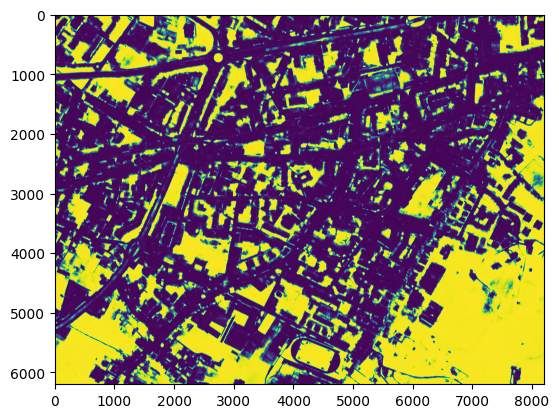

In [23]:
plt.imshow(val_preds)

In [24]:
# Compute the binary accuracy
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(val_mask, val_preds)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9418964>

Binary accuracy: $0.9419$.

In [26]:
# With best threshold
threshold = 0.48
acc = tf.keras.metrics.BinaryAccuracy(threshold=0.48)
acc.update_state(val_mask, val_preds)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9417011>

Binary accuracy: $0.9417$.

In [27]:
compute_pixelwise_retrieval_metrics(val_preds[..., 0], val_mask[..., 0])

{'auroc': 0.986083103276523,
 'fpr': array([0.00000000e+00, 0.00000000e+00, 3.14939036e-08, ...,
        9.99999906e-01, 9.99999969e-01, 1.00000000e+00]),
 'tpr': array([0.00000000e+00, 1.41451437e-06, 4.24354312e-06, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 'optimal_threshold': 0.4856,
 'optimal_fpr': 0.028803599527930764,
 'optimal_fnr': 0.029433595594020458}

Auroc: $0.99$. Best threshold: $0.485$.

Better than UNET!

**2) Polylines mask**

In [28]:
from PIL import ImageDraw
from utils.utils import get_polylines

# Thresholded binary predictions: either 0 or 1
binary_preds = (val_preds>threshold).astype('uint8')

# Compute the poly-lines
tolerance = 1.
min_area = 10
poly_lines = get_polylines(binary_preds, tolerance=tolerance, min_area=min_area)

# Compute the polylines mask
polyline_mask = np.zeros(shape=binary_preds.shape[:2], dtype=np.uint8)
polyline_mask = Image.fromarray(polyline_mask)
draw_polyline = ImageDraw.Draw(polyline_mask)
for p in poly_lines:
    draw_polyline.polygon(p, fill=1)
#polyline_mask.putpalette(get_palette())
#polyline_mask.save(join(out_folder, f"{img_basename}_polylines.png"))
polyline_mask = np.array(polyline_mask)

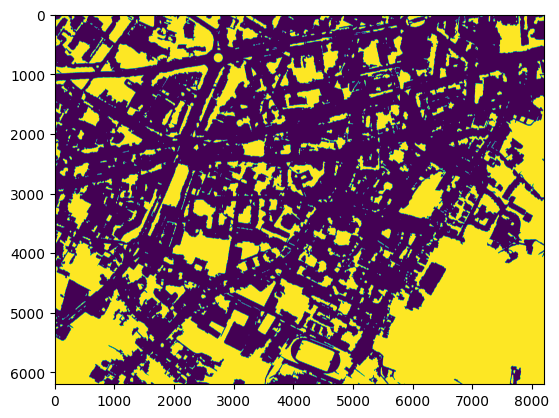

In [29]:
plt.imshow(polyline_mask)

In [30]:
# Compute the binary accuracy
acc = tf.keras.metrics.BinaryAccuracy()
acc.update_state(val_mask, polyline_mask)
acc.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9336358>

Binary accuracy: $0.9336$. Better than UNET!

*We remind that the vectorization process makes the mask better looking and more regular. The price to pay is some points of the accuracy...*

In [31]:
compute_pixelwise_retrieval_metrics(polyline_mask, val_mask[..., 0])

{'auroc': 0.93250734265874,
 'fpr': array([0.        , 0.06296264, 1.        ]),
 'tpr': array([0.        , 0.92797733, 1.        ]),
 'optimal_threshold': 1,
 'optimal_fpr': 0.039323387096774194,
 'optimal_fnr': 0.02704083398898505}

Auroc: $0.933$.

### Save the polylines mask

In [32]:
# Save polylines mask
from utils.utils import get_palette
m = Image.fromarray(polyline_mask)
m.putpalette(get_palette())
m.save("polylines.png")